In [98]:
import hitting_time_analysis as ht
import hitting_time_multichain as mch
import hitting_markov as hmk
import multichain_exponential as mce

import numpy as np
from scipy import linalg, stats
from matplotlib import pyplot as plt, colors
import polars as pl

In [2]:
Q = ht.get_naive_static_Q()

/home/davidwu/.virtualenvs/monv/lib/python3.12/site-packages/igraph/io/files.py:295: RuntimeWarning: Could not add vertex ids, there is already an 'id' vertex attribute. at src/io/graphml.c:488
  return reader(f, *args, **kwds)


In [3]:
ls = linalg.eigvals(Q)

In [56]:
hts, _ = ht.compute_static_hitting_times(Q)

In [7]:
Q_50 = mch.without(Q, 50)

In [12]:
h_50 = mch.compute_multichain_hitting_time(1, Q, index=50, precision=50)

In [24]:
Qsmol = np.array([
    [-1, 0.7, 0, 0.3],
    [0.0, -1, 1, 0],
    [0, 1, -1.2, 0.2],
    [1.4, 0, 0, -1.4],
])

In [44]:
ht.compute_static_hitting_times(Qsmol)

(array([[ 0.        ,  1.73469388,  2.73469388,  8.7       ],
        [11.71428571,  0.        ,  1.        , 11.        ],
        [10.71428571,  1.2414966 ,  0.        , 10.        ],
        [ 0.71428571,  2.44897959,  3.44897959,  0.        ]]),
 [])

In [46]:
mch.compute_all_multichain_hittings(1, Qsmol)

array([[ 0.        ,  1.73476401,  2.73472261,  8.69981065],
       [11.71446491,  0.        ,  0.99997737, 10.99985835],
       [10.713602  ,  1.24160761,  0.        ,  9.99971099],
       [ 0.71434234,  2.44885509,  3.44901075,  0.        ]])

In [49]:
rng = np.random.default_rng()

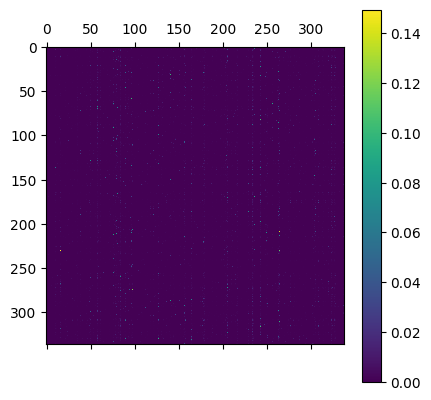

In [81]:
plt.matshow(Q - np.diag(np.diagonal(Q)))
plt.colorbar()

In [3]:
Ls, cs = mce.compute_coefficients_and_decay_rates(mce.without(Q, -1))

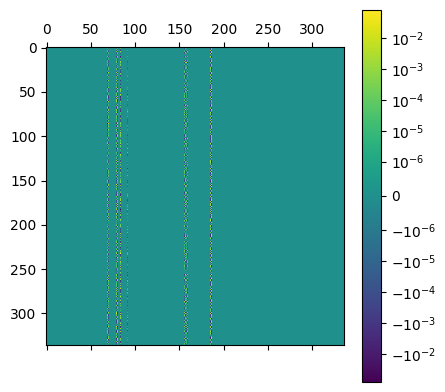

In [4]:
plt.matshow(np.imag(cs), norm=colors.SymLogNorm(linthresh=1e-6))
plt.colorbar()

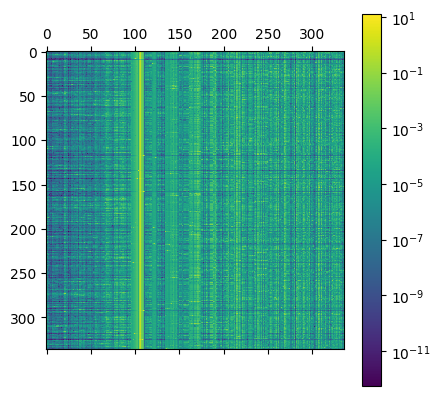

In [5]:
plt.matshow(np.abs(np.real(cs)), norm=colors.LogNorm())
plt.colorbar()

In [6]:
Lorder = np.argsort(Ls)

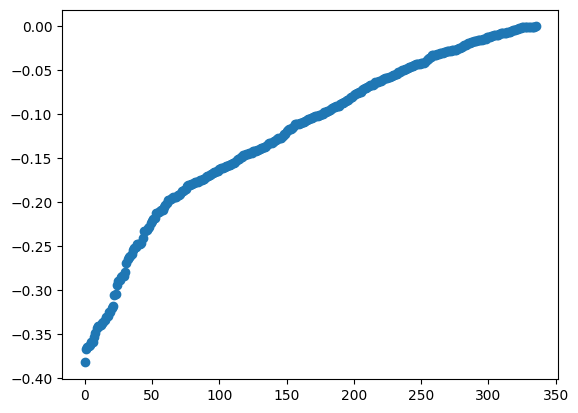

In [7]:
plt.plot(Ls[Lorder], 'o')

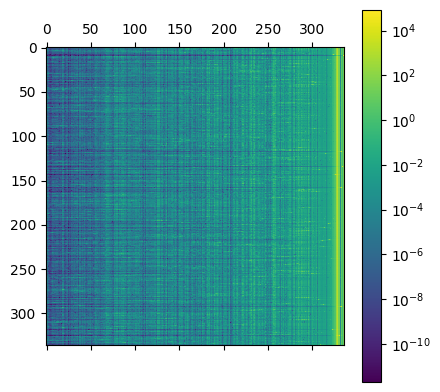

In [8]:
plt.matshow(np.abs(np.real(cs[:,Lorder]) / Ls[np.newaxis, Lorder]), norm=colors.LogNorm())
plt.colorbar()

In [9]:
solx = mch.solve_survival_ode(Q, -1, locations=np.linspace(0, 10_000, 101))
solx

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.000e+02 ...  9.900e+03  1.000e+04]
        y: [[ 1.000e+00  9.700e-01 ...  4.166e-03  3.955e-03]
            [ 1.000e+00  9.697e-01 ...  4.164e-03  3.954e-03]
            ...
            [ 1.000e+00  9.603e-01 ...  4.119e-03  3.912e-03]
            [ 1.000e+00  9.868e-01 ...  4.377e-03  4.155e-03]]
      sol: None
 t_events: None
 y_events: None
     nfev: 8078
     njev: 0
      nlu: 0

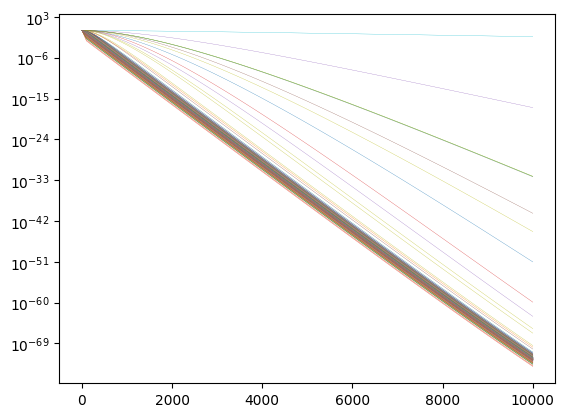

In [73]:
plt.semilogy(solx.t, solx.y.T**30, lw=0.2);


In [18]:
approx_slopes = [stats.linregress(solx.t, np.log(solxy)) for solxy in solx.y]

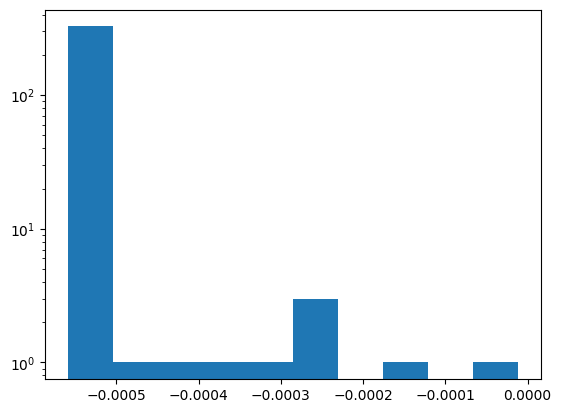

In [21]:
plt.hist([s.slope for s in approx_slopes])
plt.yscale('log')

(array([ 10.,  72., 210.,  27.,   3.,   4.,   0.,   3.,   4.,   3.]),
 array([-0.1413085 , -0.08647756, -0.03164661,  0.02318434,  0.07801528,
         0.13284623,  0.18767717,  0.24250812,  0.29733906,  0.35217001,
         0.40700096]),
 <BarContainer object of 10 artists>)

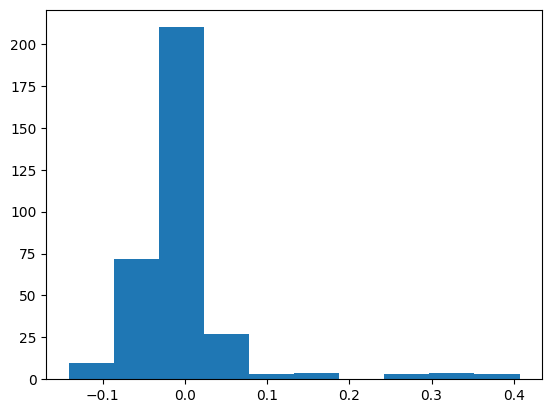

In [28]:
plt.hist([s.intercept for s in approx_slopes])

In [22]:
np.max([s.slope for s in approx_slopes])

-1.0997087028804153e-05

In [25]:
xs, cs = mch.determine_laguerre_roots_and_weights()

In [26]:
xs * 1e3

array([4.74071805e+01, 2.49923917e+02, 6.14833454e+02, 1.14319583e+03,
       1.83645455e+03, 2.69652187e+03, 3.72581451e+03, 4.92729377e+03,
       6.30451559e+03, 7.86169329e+03, 9.60377599e+03, 1.15365466e+04,
       1.36667447e+04, 1.60022212e+04, 1.85521348e+04, 2.13272043e+04,
       2.43400358e+04, 2.76055548e+04, 3.11415867e+04, 3.49696520e+04,
       3.91160849e+04, 4.36136529e+04, 4.85039862e+04, 5.38413854e+04,
       5.96991219e+04, 6.61806178e+04, 7.34412386e+04, 8.17368105e+04,
       9.15564665e+04, 1.04157524e+05])

In [29]:
np.argmax([s.slope for s in approx_slopes])

9

In [30]:
approx_slopes[9]

LinregressResult(slope=-1.0997087028804153e-05, intercept=0.008391852461831752, rvalue=-0.9971076141632333, pvalue=1.277363806443463e-112, stderr=8.424553233863642e-08, intercept_stderr=0.00048760627107039743)

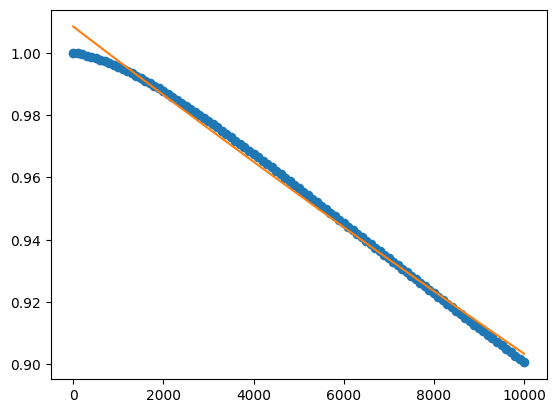

In [32]:
plt.plot(solx.t, solx.y[9,:], 'o-')
plt.plot(solx.t, np.exp(approx_slopes[9].intercept) * np.exp(solx.t * approx_slopes[9].slope))

In [36]:
targ_sol = mch.solve_survival_ode(Q, -1, locations=(xs * 1e3))

In [60]:
numer_hts = 1e3 * np.dot(cs[np.newaxis, :],   (targ_sol.y.T * np.exp(xs)[:,np.newaxis]))

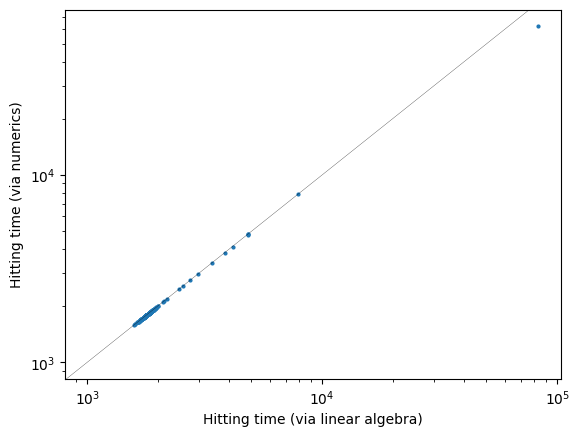

In [83]:
plt.plot(hts[:-1,-1], numer_hts.flatten(), '.', markersize=4)
plt.axline((1e3, 1e3), slope=1, color='black', lw=0.2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Hitting time (via linear algebra)')
plt.ylabel('Hitting time (via numerics)')
plt.savefig('hitting_time_analysis/numerics_comparison.png', dpi=360)

In [74]:
numer_hts_30ch = 1e3 * np.dot(cs[np.newaxis, :],   (targ_sol.y.T**30 * np.exp(xs)[:,np.newaxis]))

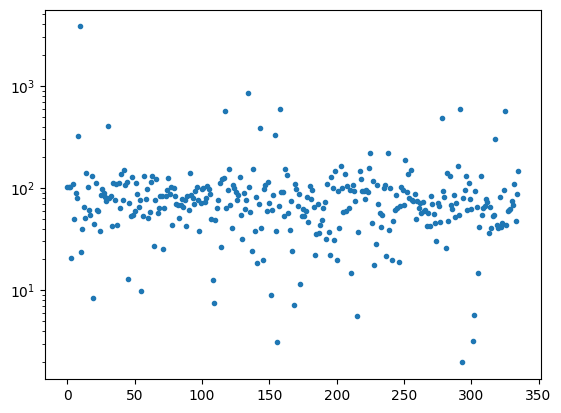

In [77]:
plt.semilogy(numer_hts_30ch.flatten(), '.')


In [87]:
SSS = 1e3

In [89]:
hitting_times_30ch = mch.compute_all_multichain_hittings(Nchains=30, Q=Q, scaling=SSS)

array([[    0.        ,  1047.22294887,   182.74059283, ...,
          807.29629163, 10314.3459888 ,   102.01557133],
       [ 1409.00390582,     0.        ,   905.71283389, ...,
          769.23481512, 10333.83269855,   102.13110052],
       [  459.43693462,  1031.45451261,     0.        , ...,
          803.58547679, 10310.28688328,   103.34527234],
       ...,
       [ 1515.75316718,  1099.35654908,  1015.97754107, ...,
            0.        , 10357.14285169,    87.46109829],
       [ 1565.38890676,  1222.38391716,  1062.88912276, ...,
          894.67780744,     0.        ,   146.27725266],
       [ 1520.97828159,  1143.30471432,  1022.06881068, ...,
          784.70490231, 10345.16273582,     0.        ]])

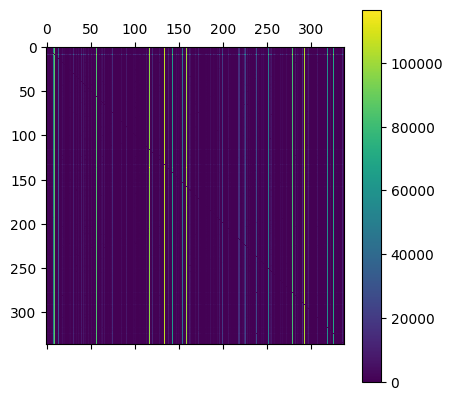

In [96]:
plt.matshow(hitting_times_30ch)
plt.colorbar()

In [ ]:
writable_df = 

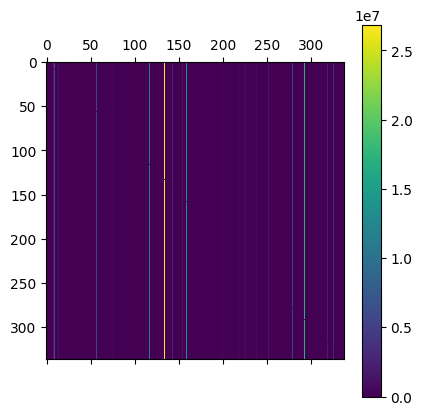

In [97]:
plt.matshow(hts)
plt.colorbar()

In [103]:
M, N = hitting_times_30ch.shape
MM, NN = np.meshgrid(np.arange(M), np.arange(N), indexing='ij')
writable_df = pl.from_dict(
    {'source': MM.ravel(),
     'target': NN.ravel(),
     'hitting_time': hitting_times_30ch.ravel(),
    }
)

In [104]:
writable_df.write_csv("./hitting_time_analysis/numer_hitting_time_30indv_chains.csv")

In [105]:
ht.get_naive_static_Q??

Signature:
ht.get_naive_static_Q(
    graph_file='./concordant_networks/shuf_static_network.graphml',
    size_file='./concordant_networks/size_14.csv',
    time_span=3650,
)
Docstring: <no docstring>
Source:   
def get_naive_static_Q(
    graph_file = "./concordant_networks/shuf_static_network.graphml",
    size_file="./concordant_networks/size_14.csv",
    time_span = (10*365),
):

    G = ig.Graph.Read(graph_file)

    graph_map = {int(k):v for k,v in zip(G.vs['name'], G.vs['id'])}
    sorted_graph_map = {k: graph_map[k] for k in sorted(graph_map.keys())}
    graph_ordering = ntc.Ordering(sorted_graph_map)

    size_order = ntc.Ordering.from_file(size_file)
    sizes = np.array([size_order(i) for i in graph_ordering.order])

    # we use the naive construction, since the null set (never return) version creates 
    # results that misrepresent the amount of time it takes to move through the system
    # We also use the internal function in order to directly pass the transition matrix

In [106]:
import igraph as ig

In [107]:
G = ig.Graph(
  edges = [
    (0, 1),
    (0, 3),
    (1, 2),
    (1, 3),
    (2, 0),
    (3, 2),
    (3, 4),
    (4, 3),
  ],
  directed = True,
  vertex_attrs = {
    'name': list('ABCDE'),
    'capacity': [10, 12, 20, 10, 3],
  },
  edge_attrs = {
    'weight': [
      30, # (0, 1),
      5, # (0, 3),
      5, # (1, 2),
      10, # (1, 3),
      15, # (2, 0),
      12, # (3, 2),
      6, # (3, 4),
      1, # (4, 3),
    ]
  }
)


In [108]:
import network_conversion as ntc

In [109]:
graph_ma = {int(k):v for kv, in zip(G.vs['name'], G.vs['id'])}

KeyError: 'Attribute does not exist'

In [111]:
list(G.vs)

[igraph.Vertex(<igraph.Graph object at 0x707b1fd10350>, 0, {'name': 'A', 'capacity': 10}),
 igraph.Vertex(<igraph.Graph object at 0x707b1fd10350>, 1, {'name': 'B', 'capacity': 12}),
 igraph.Vertex(<igraph.Graph object at 0x707b1fd10350>, 2, {'name': 'C', 'capacity': 20}),
 igraph.Vertex(<igraph.Graph object at 0x707b1fd10350>, 3, {'name': 'D', 'capacity': 10}),
 igraph.Vertex(<igraph.Graph object at 0x707b1fd10350>, 4, {'name': 'E', 'capacity': 3})]

In [115]:
v0 = G.vs[0]

In [119]:
G.vs.indices

[0, 1, 2, 3, 4]

In [118]:
G.vcount()

5